In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
from keras import optimizers
import pandas as pd
import ntpath
import imgaug.augmenters as iaaq
import random
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from PIL import ImageFile
from keras.layers.normalization import BatchNormalization


Using TensorFlow backend.


In [4]:
datadir='self_track_data'
columns= ['center' ,'left','right','steering','throttle','reverse','speed']

data= pd.read_csv(os.path.join(datadir,'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth',-1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [5]:
def path_leaf(path):
  head,tail=ntpath.split(path)
  return tail
data['center']= data['center'].apply(path_leaf)
data['left']= data['left'].apply(path_leaf)
data['right']= data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


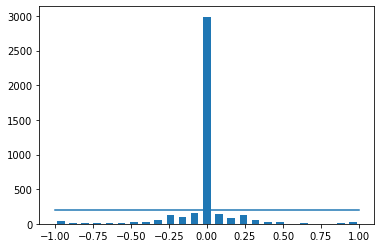

In [6]:
num_bins= 25
sample_per_bin=200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+bins[1:])*0.5
plt.bar(center,hist, width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(sample_per_bin,sample_per_bin))

4053
removed:  2790
remaining  1263


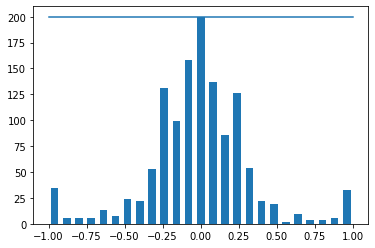

In [7]:
print(len(data))
remove_list=[]
for j in range(num_bins):
  list_=[]
  for i in range(len(data['steering'])):
    if data['steering'][i]>=bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[sample_per_bin:]
  remove_list.extend(list_)

print('removed: ',len(remove_list))
data.drop(data.index[remove_list],inplace=True)
print('remaining ', len(data))

hist, _ = np.histogram(data['steering'],(num_bins))
plt.bar(center,hist, width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(sample_per_bin,sample_per_bin))
     

In [8]:
    print(data.iloc[1])
    def load_img_steering(datadir, df):
      image_path = []
      steering = []
      for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
       
        image_path.append(os.path.join(datadir,left.strip()))
        steering.append(float(indexed_data[3])+0.15)
       
        image_path.append(os.path.join(datadir,right.strip()))
        steering.append(float(indexed_data[3])-0.15)
      image_paths = np.asarray(image_path)
      steerings = np.asarray(steering)
      return image_paths, steerings
     
    image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2018_07_16_17_11_44_413.jpg
left        left_2018_07_16_17_11_44_413.jpg  
right       right_2018_07_16_17_11_44_413.jpg 
steering   -0.05                              
throttle    0.642727                          
reverse     0                                 
speed       1.43401                           
Name: 12, dtype: object


In [9]:
    X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
    print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 3031
Valid Samples: 758


Text(0.5, 1.0, 'Validation set')

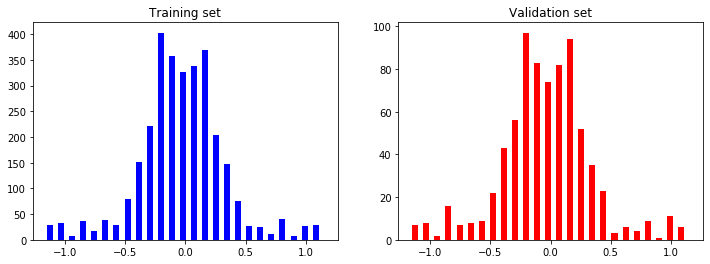

In [10]:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
    axes[0].set_title('Training set')
    axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
    axes[1].set_title('Validation set')

In [11]:
 def zoom(image):
      zoom = iaa.Affine(scale=(1, 1.3))
      image = zoom.augment_image(image)
      return image
    
 def pan(image):
      pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
      image = pan.augment_image(image)
      return image

 def img_random_brightness(image):
        brightness = iaa.Multiply((0.2, 1.2))
        image = brightness.augment_image(image)
        return image

 def img_random_flip(image, steering_angle):
        image = cv2.flip(image,1)
        steering_angle = -steering_angle
        return image, steering_angle
      
 def img_random_rain(image):
            aug = iaa.Snowflakes(flake_size=(0.1, 0.4), speed=(0.01, 0.05))
            image = aug.augment_image(image)
            return image


 def random_augment(image, steering_angle):
            image = mpimg.imread(image)
            if np.random.rand() < 0.5:
              image = pan(image)
            if np.random.rand() < 0.5:
              image = zoom(image)
            if np.random.rand() < 0.5:
              image = img_random_brightness(image)
            if np.random.rand() < 0.5:
              image, steering_angle = img_random_flip(image, steering_angle)
            if np.random.rand() < 0.5:
              image = img_random_rain(image)
            return image, steering_angle


Text(0.5, 1, 'rain Image')

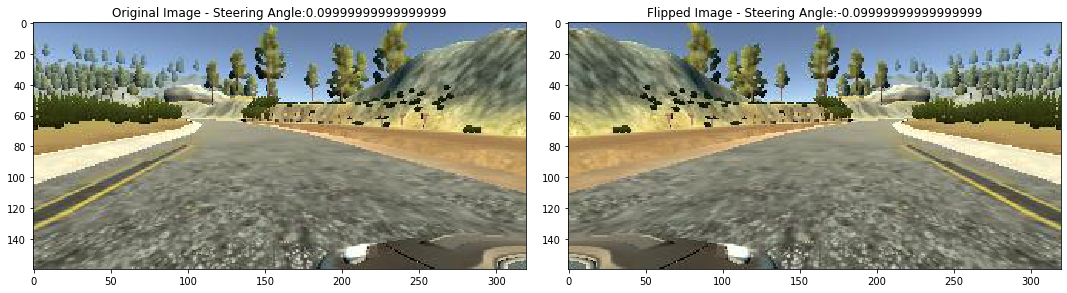

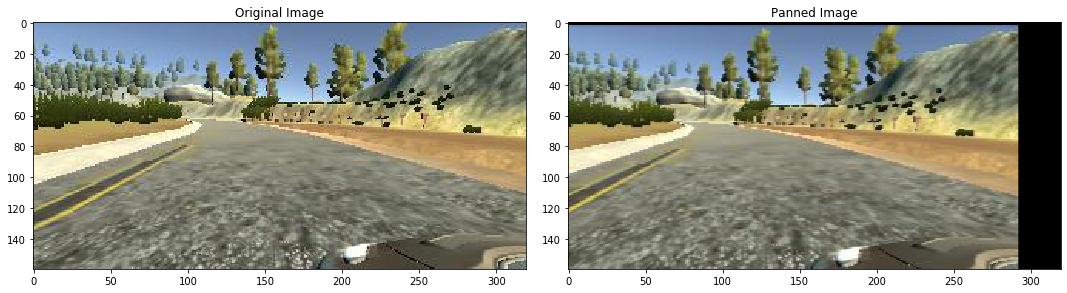

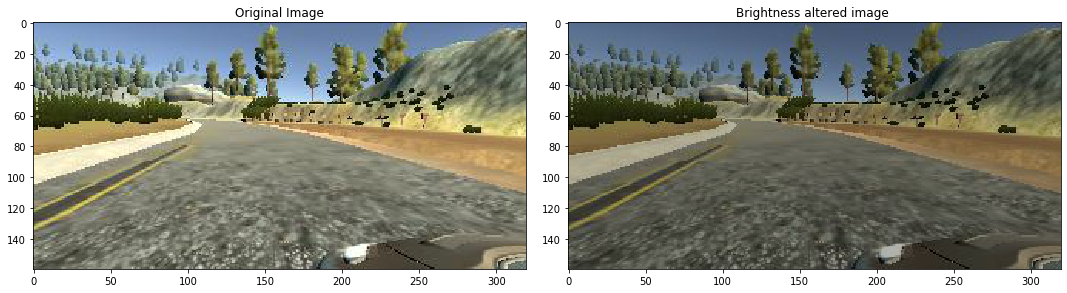

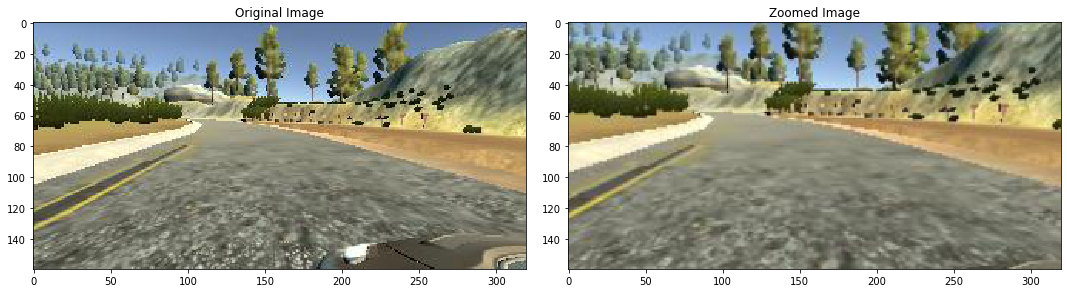

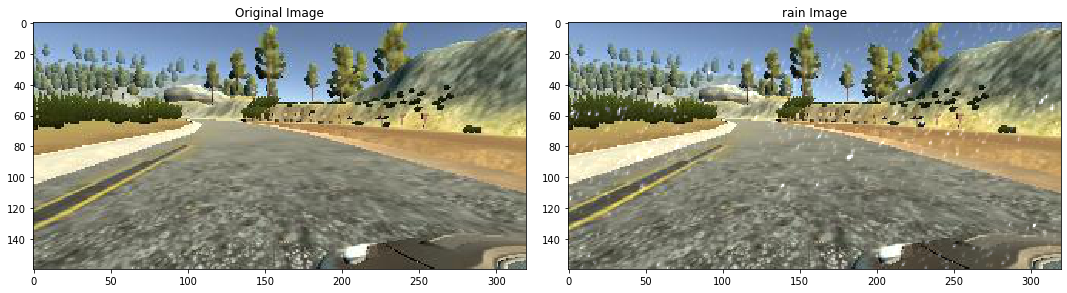

In [12]:
    random_index = random.randint(0, 1000)
    image = image_paths[random_index]
    steering_angle = steerings[random_index]

    original_image = mpimg.imread(image)
    flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
     
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    fig.tight_layout()
     
    axs[0].imshow(original_image)
    axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
     
    axs[1].imshow(flipped_image)
    axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

   #original_image = mpimg.imread(image)
    panned_image = pan(original_image)
     
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    fig.tight_layout()
     
    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')
     
    axs[1].imshow(panned_image)
    axs[1].set_title('Panned Image')

    brightness_altered_image = img_random_brightness(original_image)
     
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    fig.tight_layout()
     
    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')
     
    axs[1].imshow(brightness_altered_image)
    axs[1].set_title('Brightness altered image ')

    zoomed_image = zoom(original_image)
     
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    fig.tight_layout()
     
    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')
     
    axs[1].imshow(zoomed_image)
    axs[1].set_title('Zoomed Image')

    rain_image = img_random_rain(original_image)
     
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    fig.tight_layout()
     
    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')
     
    axs[1].imshow(rain_image)
    axs[1].set_title('rain Image')

Text(0.5, 1, 'Preprocessed Image')

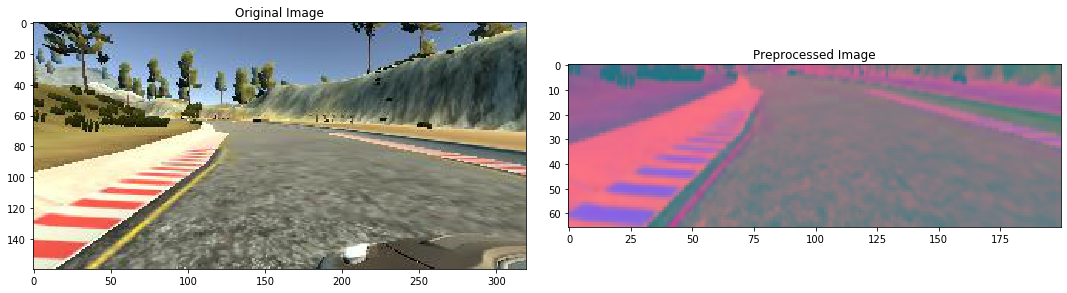

In [13]:
    def img_preprocess(img):
        img = img[60:135,:,:]
        img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        img = cv2.GaussianBlur(img,  (3, 3), 0)
        img = cv2.resize(img, (200, 66))
        img = img/255
        return img

    image = image_paths[100]
    original_image = mpimg.imread(image)
    preprocessed_image = img_preprocess(original_image)
     
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    fig.tight_layout()
    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')
    axs[1].imshow(preprocessed_image)
    axs[1].set_title('Preprocessed Image')

In [17]:
    def n_model(): 
      model = Sequential()
      model.add(Convolution2D(12, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='relu'))
      model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
      model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
      model.add(Convolution2D(48, 3, 3, activation='relu'))
      model.add(Convolution2D(60, 3, 3, activation='relu'))
      model.add(Convolution2D(60, 1, 1, activation='relu'))
      model.add(Flatten())
      model.add(Dense(300, activation = 'relu'))
      model.add(Dense(200, activation = 'relu'))   
      model.add(Dense(100, activation = 'relu'))   
      model.add(Dense(10, activation = 'relu'))
      model.add(Dense(1))
        
      adam = Adam(lr=1e-3)

      model.compile(loss='mean_squared_error',
                    optimizer=adam,
                     metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])

      return model

In [18]:
model = n_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 31, 98, 12)        912       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 47, 24)        7224      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 5, 22, 36)         21636     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 20, 48)         15600     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 18, 60)         25980     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 1, 18, 60)         3660      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1080)             

C:\Users\suyas\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, (5, 5), input_shape=(66, 200, ..., activation="relu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\suyas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
  after removing the cwd from sys.path.
C:\Users\suyas\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  """
C:\Users\suyas\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), activation="relu")`
  
C:\Users\suyas\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API:

In [19]:
    def batch_generator(image_paths, steering_ang, batch_size, istraining):
      
      while True:
        batch_img = []
        batch_steering = []
        
        for i in range(batch_size):
          random_index = random.randint(0, len(image_paths) - 1)
          
          if istraining:
            im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
         
          else:
            im = mpimg.imread(image_paths[random_index])
            steering = steering_ang[random_index]
          
          im = img_preprocess(im)
          batch_img.append(im)
          batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))  

Text(0.5, 1, 'Validation Image')

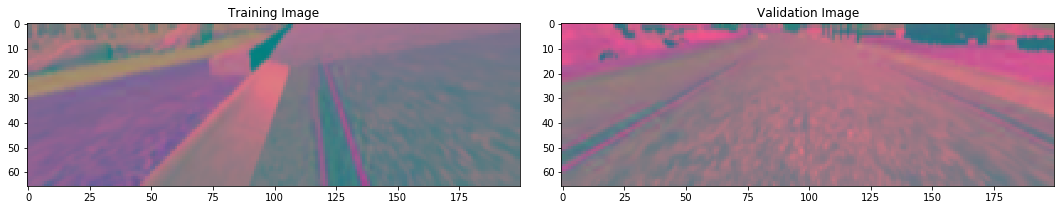

In [20]:
    x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
    x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
     
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    fig.tight_layout()
     
    axs[0].imshow(x_train_gen[0])
    axs[0].set_title('Training Image')
     
    axs[1].imshow(x_valid_gen[0])
    axs[1].set_title('Validation Image')

Epoch 1/15
300/300 [==============================] - 371s 1s/step - loss: 0.0940 - mean_squared_error: 0.0940 - mean_absolute_error: 0.2199 - mean_absolute_percentage_error: 6589214.5000 - cosine_proximity: 0.3132 - val_loss: 0.0452 - val_mean_squared_error: 0.0708 - val_mean_absolute_error: 0.1975 - val_mean_absolute_percentage_error: 6807393.5000 - val_cosine_proximity: 0.5078
Epoch 2/15
300/300 [==============================] - 371s 1s/step - loss: 0.0656 - mean_squared_error: 0.0656 - mean_absolute_error: 0.1883 - mean_absolute_percentage_error: 8452519.0000 - cosine_proximity: 0.4692 - val_loss: 0.0345 - val_mean_squared_error: 0.0488 - val_mean_absolute_error: 0.1625 - val_mean_absolute_percentage_error: 5125688.5000 - val_cosine_proximity: 0.6080
Epoch 3/15
300/300 [==============================] - 347s 1s/step - loss: 0.0612 - mean_squared_error: 0.0612 - mean_absolute_error: 0.1825 - mean_absolute_percentage_error: 8232420.5000 - cosine_proximity: 0.4858 - val_loss: 0.0587 

Text(0.5, 0, 'Epoch')

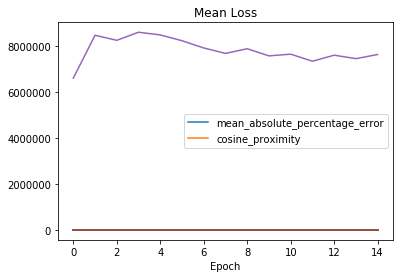

In [21]:
    history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                      steps_per_epoch=300, 
                                      epochs=15,
                                      validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                      validation_steps=200,
                                      verbose=1,
                                      shuffle = 1)


    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['training', 'validation'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    model.save('cnnmodelone.h5')

    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['mean_absolute_error'])
    plt.legend(['mean_squared_error', 'mean_absolute_error'])
    plt.title('Mean Loss')
    plt.xlabel('Epoch')
    plt.plot(history.history['mean_absolute_percentage_error'])
    plt.plot(history.history['cosine_proximity'])
    plt.legend(['mean_absolute_percentage_error','cosine_proximity'])
    plt.xlabel('Epoch')     

Text(0.5, 0, 'Epoch')

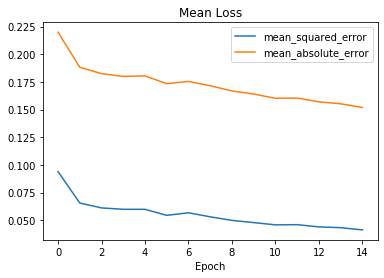

In [22]:
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['mean_absolute_error'])
    plt.legend(['mean_squared_error', 'mean_absolute_error'])
    plt.title('Mean Loss')
    plt.xlabel('Epoch')
    

Text(0.5, 0, 'Epoch')

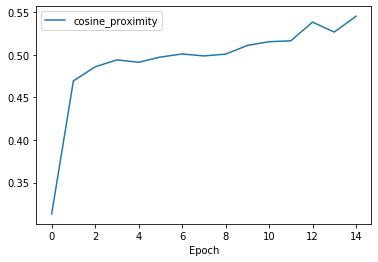

In [23]:
    plt.plot(history.history['cosine_proximity'])
    plt.legend(['cosine_proximity'])
    plt.xlabel('Epoch') 

Text(0.5, 0, 'Epoch')

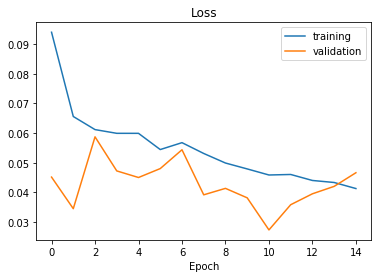

In [24]:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['training', 'validation'])
    plt.title('Loss')
    plt.xlabel('Epoch')